In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meghanagitay","key":"cb44c5ff4c1c20e2caa85474f118115b"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!cd ~/.kaggle/


In [ ]:


!kaggle competitions download -c dogs-vs-cats



100% 810M/812M [00:21<00:00, 42.9MB/s]
100% 812M/812M [00:21<00:00, 40.1MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

Copying Images to Train, Test and Validation Folders

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("validation", start_index=0, end_index=500)
make_subset("test", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=2000)



Data Preprocessing

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Model Building

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32,kernel_size=3,activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128,kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [ ]:
from keras.optimizers import Adam
model.compile(loss="binary_crossentropy",
             optimizer="adam",
              metrics=["accuracy"])

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 7s 34ms/step - loss: 0.6906 - accuracy: 0.5205 - val_loss: 0.6742 - val_accuracy: 0.5420
Epoch 2/30
63/63 [==============================] - 2s 23ms/step - loss: 0.6704 - accuracy: 0.5905 - val_loss: 0.6512 - val_accuracy: 0.6280
Epoch 3/30
63/63 [==============================] - 1s 23ms/step - loss: 0.6331 - accuracy: 0.6565 - val_loss: 0.6264 - val_accuracy: 0.6510
Epoch 4/30
63/63 [==============================] - 2s 23ms/step - loss: 0.6097 - accuracy: 0.6790 - val_loss: 0.6065 - val_accuracy: 0.6740
Epoch 5/30
63/63 [==============================] - 2s 23ms/step - loss: 0.5914 - accuracy: 0.6845 - val_loss: 0.6108 - val_accuracy: 0.6760
Epoch 6/30
63/63 [==============================] - 1s 22ms/step - loss: 0.5667 - accuracy: 0.6980 - val_loss: 0.6188 - val_accuracy: 0.6540
Epoch 7/30
63/63 [==============================] - 1s 22ms/step - loss: 0.5297 - accuracy: 0.7415 - val_loss: 0.6151 - val_accuracy: 0.6830
Epoch 8/30
63

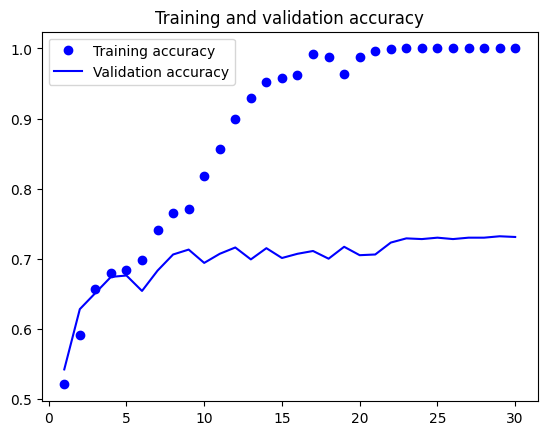

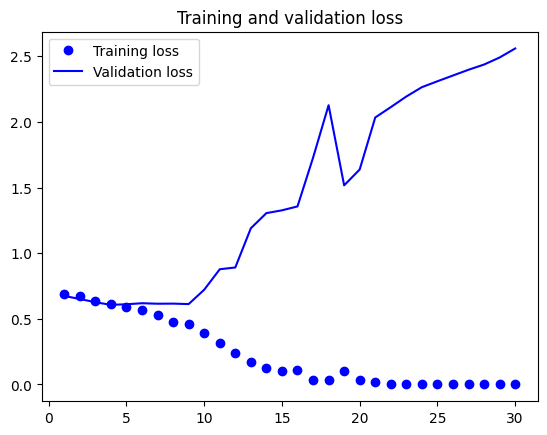

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 10ms/step - loss: 0.6243 - accuracy: 0.6510
Test accuracy: 0.651


Adding Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.6),
    ]
)

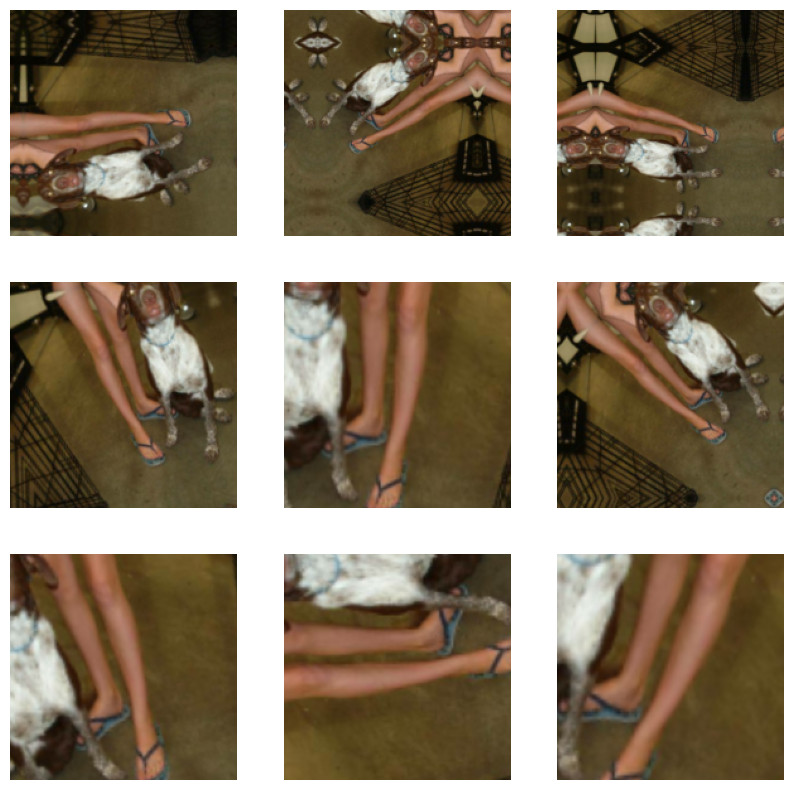

In [ ]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32,kernel_size=3,activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128,kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
#x = layers.Conv2D(filters=512,strides=2, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
from keras.optimizers import Adam
model.compile(loss="binary_crossentropy",
             optimizer=Adam(learning_rate=0.0001),
              metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

In [ ]:

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 5s 31ms/step - loss: 0.7761 - accuracy: 0.5035 - val_loss: 0.7564 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 2s 29ms/step - loss: 0.7297 - accuracy: 0.5820 - val_loss: 0.7165 - val_accuracy: 0.5720
Epoch 3/30
63/63 [==============================] - 2s 30ms/step - loss: 0.7017 - accuracy: 0.6205 - val_loss: 0.6932 - val_accuracy: 0.6610
Epoch 4/30
63/63 [==============================] - 2s 29ms/step - loss: 0.6748 - accuracy: 0.6405 - val_loss: 0.6517 - val_accuracy: 0.6600
Epoch 5/30
63/63 [==============================] - 2s 31ms/step - loss: 0.6407 - accuracy: 0.6625 - val_loss: 0.6266 - val_accuracy: 0.6810
Epoch 6/30
63/63 [==============================] - 2s 29ms/step - loss: 0.6090 - accuracy: 0.7030 - val_loss: 0.5905 - val_accuracy: 0.7150
Epoch 7/30
63/63 [==============================] - 1s 22ms/step - loss: 0.5872 - accuracy: 0.7220 - val_loss: 0.5940 - val_accuracy: 0.7160
Epoch 8/30
63

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


32/32 [==============================] - 1s 9ms/step - loss: 0.5681 - accuracy: 0.7410
Test accuracy: 0.741


Choosing a Random train sample size

Train Sample 2000

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("validation", start_index=0, end_index=500)
make_subset("test", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=3000)


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_2000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - 3s 23ms/step - loss: 0.4282 - accuracy: 0.8455 - val_loss: 0.5073 - val_accuracy: 0.7910
Epoch 2/30
125/125 [==============================] - 3s 23ms/step - loss: 0.3188 - accuracy: 0.8817 - val_loss: 0.5004 - val_accuracy: 0.7980
Epoch 3/30
125/125 [==============================] - 3s 19ms/step - loss: 0.2707 - accuracy: 0.9115 - val_loss: 0.5062 - val_accuracy: 0.8030
Epoch 4/30
125/125 [==============================] - 2s 19ms/step - loss: 0.2262 - accuracy: 0.9252 - val_loss: 0.5214 - val_accuracy: 0.7930
Epoch 5/30
125/125 [==============================] - 3s 20ms/step - loss: 0.1878 - accuracy: 0.9452 - val_loss: 0.5477 - val_accuracy: 0.8050
Epoch 6/30
125/125 [==============================] - 3s 20ms/step - loss: 0.1445 - accuracy: 0.9595 - val_loss: 0.5830 - val_accuracy: 0.8150
Epoch 7/30
125/125 [==============================] - 3s 20ms/step - loss: 0.1350 - accuracy: 0.9615 - val_loss: 0.5807 - val_accuracy: 0.8040

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation_2000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 12ms/step - loss: 0.5336 - accuracy: 0.7810
Test accuracy: 0.781


Train Sample: 3000

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_5")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("validation", start_index=0, end_index=500)
make_subset("test", start_index=500, end_index=1000)
make_subset("train", start_index=2000, end_index=4000)


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_30000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
125/125 [==============================] - 3s 24ms/step - loss: 0.4014 - accuracy: 0.8595 - val_loss: 0.5851 - val_accuracy: 0.7700
Epoch 2/20
125/125 [==============================] - 3s 23ms/step - loss: 0.2295 - accuracy: 0.9243 - val_loss: 0.5646 - val_accuracy: 0.8050
Epoch 3/20
125/125 [==============================] - 3s 20ms/step - loss: 0.1613 - accuracy: 0.9532 - val_loss: 0.6713 - val_accuracy: 0.8070
Epoch 4/20
125/125 [==============================] - 3s 20ms/step - loss: 0.1125 - accuracy: 0.9730 - val_loss: 0.7232 - val_accuracy: 0.8080
Epoch 5/20
125/125 [==============================] - 3s 20ms/step - loss: 0.0809 - accuracy: 0.9847 - val_loss: 0.7073 - val_accuracy: 0.8110
Epoch 6/20
125/125 [==============================] - 3s 20ms/step - loss: 0.0596 - accuracy: 0.9927 - val_loss: 0.8641 - val_accuracy: 0.8060
Epoch 7/20
125/125 [==============================] - 3s 19ms/step - loss: 0.0488 - accuracy: 0.9960 - val_loss: 0.8803 - val_accuracy: 0.8060

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation_30000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 9ms/step - loss: 0.5876 - accuracy: 0.7880
Test accuracy: 0.788


Train Sample: 4000

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("validation", start_index=0, end_index=500)
make_subset("test", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=5000)


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 8000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_4000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
250/250 [==============================] - 5s 21ms/step - loss: 0.2585 - accuracy: 0.9166 - val_loss: 0.4791 - val_accuracy: 0.8240
Epoch 2/20
250/250 [==============================] - 5s 18ms/step - loss: 0.1347 - accuracy: 0.9644 - val_loss: 0.5674 - val_accuracy: 0.8210
Epoch 3/20
250/250 [==============================] - 5s 18ms/step - loss: 0.0995 - accuracy: 0.9746 - val_loss: 0.5733 - val_accuracy: 0.8140
Epoch 4/20
250/250 [==============================] - 5s 19ms/step - loss: 0.0594 - accuracy: 0.9909 - val_loss: 0.7475 - val_accuracy: 0.8150
Epoch 5/20
250/250 [==============================] - 5s 18ms/step - loss: 0.0514 - accuracy: 0.9934 - val_loss: 0.7044 - val_accuracy: 0.8260
Epoch 6/20
250/250 [==============================] - 5s 18ms/step - loss: 0.0526 - accuracy: 0.9930 - val_loss: 0.7537 - val_accuracy: 0.8200
Epoch 7/20
250/250 [==============================] - 5s 18ms/step - loss: 0.0362 - accuracy: 0.9979 - val_loss: 0.8301 - val_accuracy: 0.8090

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation_4000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 10ms/step - loss: 0.5068 - accuracy: 0.8250
Test accuracy: 0.825


In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()


58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.6)
    ]
)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
from keras.optimizers import Adam
model.compile(loss="binary_crossentropy",
             optimizer=Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="vgg16_with_data_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
250/250 [==============================] - 11s 43ms/step - loss: 0.2420 - accuracy: 0.9001 - val_loss: 0.0966 - val_accuracy: 0.9630
Epoch 2/20
250/250 [==============================] - 11s 43ms/step - loss: 0.2154 - accuracy: 0.9118 - val_loss: 0.0861 - val_accuracy: 0.9650
Epoch 3/20
250/250 [==============================] - 11s 43ms/step - loss: 0.1925 - accuracy: 0.9212 - val_loss: 0.0774 - val_accuracy: 0.9750
Epoch 4/20
250/250 [==============================] - 11s 43ms/step - loss: 0.2105 - accuracy: 0.9144 - val_loss: 0.0551 - val_accuracy: 0.9790
Epoch 5/20
250/250 [==============================] - 10s 41ms/step - loss: 0.1836 - accuracy: 0.9243 - val_loss: 0.0692 - val_accuracy: 0.9670
Epoch 6/20
250/250 [==============================] - 10s 41ms/step - loss: 0.1704 - accuracy: 0.9289 - val_loss: 0.1031 - val_accuracy: 0.9590
Epoch 7/20
250/250 [==============================] - 10s 41ms/step - loss: 0.1643 - accuracy: 0.9365 - val_loss: 0.0618 - val_accuracy:

In [ ]:
test_model = keras.models.load_model(
    "vgg16_with_data_augmentation.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.0650 - accuracy: 0.9830
Test accuracy: 0.983
